# Report

## Gather

- Neste ponto foram feitos esforços para adquirir os dados necessários para o projeto. Primeiramente, foi gerado um arquivo no formato `TOML` que contém os tokens usados na API do Twitter, este arquivo é aberto como um dicionário pelo python utilizando a extensão toml. As variáveis constantes (em maiúsculo) são criadas com os valores desse token facilitando a manutenção do código e o objeto da API é criado. São utilizados `wait_on_rate_limit` e `wait_on_rate_limit_notify` para que, quando o tempo limite for excedido, a api espere para contínuar e avise dessa pausa;
- Utilizando a url fornecida para o projeto 2, o arquivo `image-predictions.tsv` é carregado como um DataFrame diretamente, aproveitando os recursos das últimas versões do pandas que tem a capacidade de fazer download diretamente ao abrir o url;
- O arquivo `twitter-archive-enhanced.csv` é carregado como o dataframe `twitter_archive`;
- Utilizando os identificadores do dataframe `image_predicion` e a API do twitter, os tweets são baixados no formato json e gravados no arquivo `tweet_json.txt` linha por linha usando a forma de gravação `append` de arquivos do python. Também foi adicionado o comando mágico do ipython `%%time` para calcular o tempo de execução;
- Utilizando o arquivo `tweet_json.txt` e acessar cada linha deste arquivo pegando as informações úteis e adicionando-as a um dataframe vazio chamado `df_tweets`.

## Assess
- Acessa informações úteis de cada dataframe para entender o conteúdo de seus dados, algumas das informações que são acessadas são: `sample(10)` para enxergar 10 amostras aleatórias; `info()` para verificar valores faltantes e os tipos de dados de cada coluna; `duplicated()` para verificar se valores estão duplicados. Ainda foram feitas outras visualizações que ajudaram a esclarecer o que poderia ser melhorado, como retweets existentes e replys de tweets originais;
- Cada link de `extended_urls` foi acessado para descobrir se existiam tweets inexistentes e assim facilitar suas remoções;
- Uma lista de tarefas para melhorar a qualidade e arrumação dos dataframes foi criada para servir como guia na limpeza.

## Clean
- Primeiramente, para cada item da lista foi criada uma definição, ou seja, uma informação do que foi realizado;
- Essa ordem de limpeza foi definida por tabela, onde toda a limpeza de uma tabela era feita antes de prosseguir para a seguinte, a menos que a limpeza não fosse possível;
- A baixo de cada definição, foi realizada a limpeza do código e um ou mais testes para verificar a corretitude da tabela depois da limpeza;
- Ao terminar as limpezas de qualidade se seguiu para as limpezas de arrumação onde foi feita a junção das tabelas com as colunas necessárias e ideais;
- O novo dataframe gerado pela junção ainda teve de receber alguns procedimentos de limpeza que serviram para melhorar a qualidade antes de ser salvo como `twitter_archive_master.csv`

## Analyze
- Algumas pequenas análises descritivas foram realizadas, com a geração de alguns gráficos, e foram escritos alguns insights dos resultados.

# Wrangle Act

## Gather

In [1]:
import re
import json
import toml
import time
import tweepy
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load twitter tokens
parse_tokens = toml.load('tokens.toml')

# Set tweepy tokens
CONSUMER_KEY = parse_tokens['tokens']['consumer_key']
CONSUMER_SECRET = parse_tokens['tokens']['consumer_secret']
ACCESS_TOKEN = parse_tokens['tokens']['access_token']
ACCESS_SECRET = parse_tokens['tokens']['access_secret']

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
r = requests.get(url)  
with open('/path/I/want/to/save/file/to/file_name.pdf', 'wb') as f:
    f.write(r.content)

In [91]:
# Download image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)  
with open('image_predictions.tsv', 'wb') as f:
    f.write(r.content)

image_pretictions = pd.read_table('image_predictions.tsv')

In [4]:
# Load tweets
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
%%time
# Take tweet json by tweet_id:
# *AVISO*: Execução demorada
id_404_erros = []
# tweets = twitter_archive[(twitter_archive.retweeted_status_id.isnull()) & (twitter_archive.in_reply_to_status_id.isnull())]
tweets = image_pretictions
for tweet_id in tweets.tweet_id:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        if tweet.user.id == 4196983835:
            with open('tweet_json.txt', 'a') as outfile:
                json.dump(tweet._json, outfile)
                outfile.write('\n')
    except tweepy.TweepError:
        #         if tweepy.TweepError.message[0]['code'] == 404:
        id_404_erros.append(tweet_id)
        continue

Rate limit reached. Sleeping for: 547
Rate limit reached. Sleeping for: 578


CPU times: user 1min 6s, sys: 2.54 s, total: 1min 9s
Wall time: 31min 56s


In [6]:
# Gera DataFrame de tweets puxados por id
df_tweets = pd.DataFrame(columns=[
                         'tweet_id', 'text', 'retweet_count', 'favorite_count', 'jpg_url', 'url', 'expanded_urls'])

with open('tweet_json.txt', 'r') as file:
    for line in file:
        try:
            line_json = json.loads(line)
            
            if 'media' not in line_json['entities']:
                continue
            line_dict = {
                'tweet_id': line_json['id_str'],
                'text': line_json['full_text'],
                'retweet_count': line_json['retweet_count'],
                'favorite_count': line_json['favorite_count'],
                'jpg_url': line_json['entities']['media'][0]['media_url_https'],
                'url': line_json['entities']['media'][0]['url'],
                'expanded_urls': line_json['entities']['media'][0]['expanded_url']
            }

            df_tweets = df_tweets.append(
                pd.Series(line_dict).to_frame().transpose(), ignore_index=True) # Transpoem do formato de Serie para DataFrame

        except Exception:
            raise Exception(line)
df_tweets.head()

,tweet_id,text,retweet_count,favorite_count,jpg_url,url,expanded_urls
0,666020888022790149,Here we have a Japanese Irish Setter. Lost eye...,504,2533,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888...
1,666029285002620928,This is a western brown Mitsubishi terrier. Up...,47,128,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285...
2,666033412701032449,Here is a very happy pup. Big fan of well-main...,43,124,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412...
3,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,139,294,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226...
4,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,41,107,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248...


## Assess

In [7]:
# Show dataframe loaded head.
image_pretictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
909,700518061187723268,https://pbs.twimg.com/media/Cbi9dI_UYAAgkyC.jpg,1,American_Staffordshire_terrier,0.569501,True,Staffordshire_bullterrier,0.211308,True,Chihuahua,0.121839,True
1355,760290219849637889,https://pbs.twimg.com/ext_tw_video_thumb/76028...,1,Old_English_sheepdog,0.302200,True,Lhasa,0.258803,True,briard,0.179200,True
1326,757354760399941633,https://pbs.twimg.com/media/CoKqIndWgAAattd.jpg,1,Italian_greyhound,0.914667,True,whippet,0.047774,True,ice_lolly,0.015477,False
2009,878281511006478336,https://pbs.twimg.com/media/DDBIX9QVYAAohGa.jpg,1,basset,0.320420,True,collie,0.215975,True,Appenzeller,0.128507,True
735,687096057537363968,https://pbs.twimg.com/media/CYkON6CVAAAPXAc.jpg,1,Labrador_retriever,0.417107,True,Chesapeake_Bay_retriever,0.341730,True,German_short-haired_pointer,0.177702,True
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1994,874057562936811520,https://pbs.twimg.com/media/DCFGtdoXkAEsqIw.jpg,1,flat-coated_retriever,0.832177,True,black-and-tan_coonhound,0.040437,True,Newfoundland,0.028228,True
1019,710140971284037632,https://pbs.twimg.com/media/Cdrtcr-W4AAqi5H.jpg,1,Pekinese,0.953170,True,papillon,0.019517,True,Japanese_spaniel,0.005821,True
983,707411934438625280,https://pbs.twimg.com/media/CdE7ZktXIAEiWLj.jpg,1,Lakeland_terrier,0.738277,True,Airedale,0.028515,True,giant_schnauzer,0.024876,True
2017,880095782870896641,https://pbs.twimg.com/media/DDa6ckbXgAAM1vV.jpg,1,miniature_pinscher,0.120298,True,Rhodesian_ridgeback,0.106395,True,beagle,0.106073,True


In [8]:
image_pretictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [9]:
image_pretictions.loc[image_pretictions.jpg_url.isnull(), :]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [10]:
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1396,699788877217865730,NaN,NaN,2016-02-17 02:54:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Nala. She's a Freckled High Brusc...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699788877...,12,10,Nala,None,None,None,None
680,788908386943430656,NaN,NaN,2016-10-20 01:03:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Lucy. She destroyed not one, but two r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/788908386...,11,10,Lucy,None,None,None,None
2214,668544745690562560,NaN,NaN,2015-11-22 21:41:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",It is an honor to rate this pup. He is a Snork...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668544745...,10,10,None,None,None,None,None
1284,708479650088034305,NaN,NaN,2016-03-12 02:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Bear. He's a Beneboop Cumberclap. Extreme...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708479650...,13,10,Bear,None,None,None,None
726,782598640137187329,NaN,NaN,2016-10-02 15:10:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Timmy. He's quite large. According to ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782598640...,11,10,Timmy,None,None,None,None
802,772193107915964416,NaN,NaN,2016-09-03 22:02:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Willem. He's a Penn State pupper. Thin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772193107...,12,10,Willem,None,None,pupper,None
1024,746507379341139972,NaN,NaN,2016-06-25 00:56:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shiloh. She did not pass the soft mout...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746507379...,10,10,Shiloh,None,None,None,None
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,None,None,pupper,None
930,754449512966619136,NaN,NaN,2016-07-16 22:55:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dex. He can see into your past and fut...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754449512...,11,10,Dex,None,None,None,None
1799,677187300187611136,NaN,NaN,2015-12-16 18:03:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we see a Byzantine Rigatoni. Very aerodyn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677187300...,9,10,None,None,None,None,None


In [11]:
# Retweets e replys
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
# Formato do texto
twitter_archive.loc[0, 'text']

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [13]:
# Retweet externo existente
twitter_archive.loc[546, :]

tweet_id                                                     805823200554876929
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                             2016-12-05 17:16:37 +0000
source                        <a href="http://twitter.com/download/iphone" r...
text                          RT @dog_rates: This is Reginald. He's one magi...
retweeted_status_id                                                 7.84183e+17
retweeted_status_user_id                                            4.19698e+09
retweeted_status_timestamp                            2016-10-07 00:06:50 +0000
expanded_urls                 https://vine.co/v/5ghHLBMMdlV,https://vine.co/...
rating_numerator                                                             12
rating_denominator                                                           10
name                                    

In [14]:
# Reply
twitter_archive.loc[twitter_archive.in_reply_to_status_id.notnull(), :]
twitter_archive.loc[149, :]

tweet_id                                                     863079547188785154
in_reply_to_status_id                                               6.67152e+17
in_reply_to_user_id                                                 4.19698e+09
timestamp                                             2017-05-12 17:12:53 +0000
source                        <a href="http://twitter.com/download/iphone" r...
text                          Ladies and gentlemen... I found Pipsy. He may ...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/863079547...
rating_numerator                                                             14
rating_denominator                                                           10
name                                    

In [15]:
# Lista de replys
twitter_archive[twitter_archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [16]:
# Lista de retweets
twitter_archive[twitter_archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [17]:
# Valores que não foram verificados com machine learning
temp = pd.merge(twitter_archive, image_pretictions,
                on=['tweet_id'], how='outer')
temp[temp.p1.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,878604707211726852,NaN,NaN,2017-06-24 13:24:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Martha is stunning how h*ckin dare you. 13/10 ...,NaN,NaN,NaN,https://twitter.com/bbcworld/status/8785998685...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Verificando existencia de duplicados
twitter_archive.tweet_id.duplicated().sum()

0

In [19]:
image_pretictions.tweet_id.duplicated().sum()

0

In [20]:
twitter_archive[twitter_archive.rating_numerator == 1776].text.values

array(["This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"],
      dtype=object)

In [22]:
%%time
# Verificando links de tweets inexistentes
# AVISO: Execução demorada.
count = 0
id_404 = []
for index, row in twitter_archive[twitter_archive.expanded_urls.notna()].iterrows():
    if requests.get(row.expanded_urls.split(',')[0]).status_code == 404:
        print(row.expanded_urls.split(',')[0])
        count += 1
        id_404.append(row.tweet_id)
count

https://twitter.com/4bonds2carbon/status/885517367337512960
https://twitter.com/loganamnosis/status/872657584259551233/photo/1
https://twitter.com/perfy/status/855857318168150016
https://www.petfinder.com/petdetail/37334596
https://twitter.com/brianstack153/status/796796054100471809
https://twitter.com/KennyFromDaBlok/status/837011344666812416/photo/1
https://twitter.com/stevekopack/status/834086676934836224
https://www.petfinder.com/petdetail/34918210
https://twitter.com/dog_rates/status/680055455951884288/photo/1
https://twitter.com/littlewiewel/status/800852955880628224
https://www.patreon.com/WeRateDogs
https://weratedogs.com/pages/about-us
https://twitter.com/dog_rates/status/754011816964026368/photo/1
https://twitter.com/dog_rates/status/680055455951884288/photo/1
CPU times: user 1min 26s, sys: 4.06 s, total: 1min 30s
Wall time: 33min 50s


In [23]:
# Mostra linhas que url retorna erro 404
twitter_archive[twitter_archive.tweet_id.isin(id_404)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @loganamnosis: Penelope here is doing me qu...,8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657...,14,10,None,None,None,None,None
190,855857698524602368,NaN,NaN,2017-04-22 18:55:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...","HE'S LIKE ""WAIT A MINUTE I'M AN ANIMAL THIS IS...",NaN,NaN,NaN,https://twitter.com/perfy/status/8558573181681...,13,10,None,None,None,None,None
237,847157206088847362,NaN,NaN,2017-03-29 18:43:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Daisy. She's been pup for adoption for mo...,NaN,NaN,NaN,"https://www.petfinder.com/petdetail/37334596,h...",11,10,Daisy,None,None,None,None
256,843981021012017153,NaN,NaN,2017-03-21 00:22:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",HE WAS DOING A SNOOZE NO SHAME IN A SNOOZE 13/...,NaN,NaN,NaN,https://twitter.com/brianstack153/status/79679...,13,10,None,None,None,None,None
298,837012587749474308,NaN,NaN,2017-03-01 18:52:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @KennyFromDaBlok: 14/10 h*ckin good hats. w...,8.370113e+17,7.266347e+08,2017-03-01 18:47:10 +0000,https://twitter.com/KennyFromDaBlok/status/837...,14,10,None,None,None,None,None
323,834089966724603904,NaN,NaN,2017-02-21 17:18:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",DOGGO ON THE LOOSE I REPEAT DOGGO ON THE LOOSE...,NaN,NaN,NaN,https://twitter.com/stevekopack/status/8340866...,10,10,None,doggo,None,None,None
344,832032802820481025,NaN,NaN,2017-02-16 01:04:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Miguel. He was the only remaining dogg...,NaN,NaN,NaN,"https://www.petfinder.com/petdetail/34918210,h...",12,10,Miguel,doggo,None,None,None
506,812747805718642688,NaN,NaN,2016-12-24 19:52:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Sammy. At first I was like...,6.800555e+17,4.196984e+09,2015-12-24 16:00:30 +0000,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None
577,800855607700029440,NaN,NaN,2016-11-22 00:17:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Lin_Manuel: 11/10 would recommend. https:/...,8.008540e+17,7.992370e+07,2016-11-22 00:10:52 +0000,https://twitter.com/littlewiewel/status/800852...,11,10,None,None,None,None,None


In [24]:
df_tweets.sample(10)

,tweet_id,text,retweet_count,favorite_count,jpg_url,url,expanded_urls
745,687664829264453632,Meet Opal. He's a Belgian Dijon Poofster. Upse...,546,2039,https://pbs.twimg.com/media/CYsTg1XUsAEPjxE.jpg,https://t.co/IAt3jRZ5ez,https://twitter.com/dog_rates/status/687664829...
2037,886366144734445568,This is Roscoe. Another pupper fallen victim t...,3139,20836,https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg,https://t.co/RGE08MIJox,https://twitter.com/dog_rates/status/886366144...
785,690374419777196032,This is Phred. He's an Albanian Flepperkush. T...,919,3432,https://pbs.twimg.com/media/CZSz3vWXEAACElU.jpg,https://t.co/VpfFCKE28C,https://twitter.com/dog_rates/status/690374419...
24,666353288456101888,Here we have a mixed Asiago from the Galápagos...,71,216,https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg,https://t.co/tltQ5w9aUO,https://twitter.com/dog_rates/status/666353288...
315,671735591348891648,This is Oscar. He's ready for Christmas. 11/10...,778,1476,https://pbs.twimg.com/media/CVJ79MxWEAEIWVi.jpg,https://t.co/TON0Irzgwr,https://twitter.com/dog_rates/status/671735591...
853,696713835009417216,This is Trevith. He's a Swiss Mountain Roadwoo...,689,2494,https://pbs.twimg.com/media/Cas5h-wWcAA3nAc.jpg,https://t.co/6J8Ibwy1X6,https://twitter.com/dog_rates/status/696713835...
1638,807621403335917568,This is Ollie Vue. He was a 3 legged pupper on...,4043,15614,https://pbs.twimg.com/media/CzU_YVGUoAA1Bla.jpg,https://t.co/qTRY2qX9y4,https://twitter.com/dog_rates/status/807621403...
1265,749403093750648834,Duuun dun... duuun dun... dunn dun. dunn dun....,588,2774,https://pbs.twimg.com/media/CmZqIslWIAQFiqe.jpg,https://t.co/9qdJ2Q1Cwx,https://twitter.com/dog_rates/status/749403093...
2008,879862464715927552,This is Romeo. He would like to do an entrance...,3441,21962,https://pbs.twimg.com/media/DDXmPreXUAA3QGJ.jpg,https://t.co/Qh5aEkRQm9,https://twitter.com/dog_rates/status/879862464...
313,671561002136281088,This is the best thing I've ever seen so sprea...,7442,13052,https://pbs.twimg.com/media/CVHdK-7WwAAsuyc.jpg,https://t.co/q6RsuOVYwU,https://twitter.com/dog_rates/status/671561002...


In [25]:
# valores duplicados
df_tweets.tweet_id.value_counts().head(10)

729463711119904772    1
809808892968534016    1
831309418084069378    1
683498322573824003    1
775898661951791106    1
826476773533745153    1
670433248821026816    1
852226086759018497    1
743210557239623680    1
678969228704284672    1
Name: tweet_id, dtype: int64

### Quality

#### `image_pretictions` table
- <del>Tipo de dados errado em `tweet_id`;</de>
- <del>Textos com diferentes formas minusculos e maiusculos nas colunas `p1`, `p2` e `p3`;</del>
- <del>Separação dos textos das colunas `p1`, `p2` e `p3` usando `_` ao invés de espaço.</del>

#### `twitter_archive` table
- <del>`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` com valores incorres no formato `6.67152e+17`;</del>
- <del>Tipo de dados errado em `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `timestamp`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`;</del>
- <del>Valores nulos sendo representados como `nan` ao invés de `NaN` nas `colunas in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_id` e `retweeted_status_user_id`;</del>
- <del>Valores nulos sendo representados como `None` em `doggo`, `floofer`, `pupper` e `puppo`;</del>
- <del>Url repetidas na coluna `expanded_urls`;</del>
- <del>Alguns links em expanded_urls levam a páginas com error 404;</de>
- <del>Nem todos os ids tem predições.</del>
- <del>Urls vazias;</del>
- <del>Nomes de pets como `None` e `a`.</del>

#### `df_tweets` table
-

#### `twitter_archive_master` table
- <del>Limpar urls que não levam a dog_rates</del>

### Tidiness
- <del>Colunas `source` desnecessária em `twitter_archive`;</del>
- <del>Retweets existentes, colunas `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`.</del>
- <del>Replys existentes, colunas `in_reply_to_status_id`, `in_reply_to_user_id`;</del>
- <del>`text` contém (texto, nota, url) em `twitter_archive` e `df_tweets`;</del>
- <del>Quatro colunas em `twitter_archive` (`doggo`, `floofer`, `pupper` e `puppo`) ao invés de uma;</del>
- <del>Denominador se mostra desnecessário sendo sempre 10 em `twitter_archive` na coluna `rating_denominator`;</del>
- <del>Colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`;</del>
- <del>Numero de imagens na coluna `img_num` se mostra desnecessário em `image_predictions`.</del>
- <del>Junção de `df_tweets`, `image_predicitions` e `twitter_archive`;</del>

## Clean

In [26]:
image_pretictions_clean = image_pretictions.copy()
twitter_archive_clean = twitter_archive.copy()
df_tweets_clean = df_tweets.copy()

### Clean - `image_pretictions` table
#### Define - Tipo de dados errado em `tweet_id`
- Modifica o tipos dos valores da coluna `tweet_id` de inteiro para string usando `astype`

#### Code

In [27]:
image_pretictions_clean.tweet_id = image_pretictions_clean.tweet_id.astype(
    'str')

#### Test

In [28]:
image_pretictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Define
- Textos com diferentes formas minusculos e maiusculos nas colunas p1, p2 e p3

#### Code

In [29]:
image_pretictions_clean.p1 = image_pretictions_clean.p1.apply(
    lambda x: x.lower().replace('_', ' '))
image_pretictions_clean.p2 = image_pretictions_clean.p2.apply(
    lambda x: x.lower().replace('_', ' '))
image_pretictions_clean.p3 = image_pretictions_clean.p3.apply(
    lambda x: x.lower().replace('_', ' '))

#### Test

In [30]:
image_pretictions_clean.p1.sample(10)

479               borzoi
1685    miniature poodle
435        toilet tissue
259            chihuahua
1305            bluetick
1322              geyser
364               tusker
246                 wool
486               vizsla
1488              briard
Name: p1, dtype: object

In [31]:
image_pretictions_clean.p2.sample(10)

1498      golden retriever
264                 beagle
1439               basenji
757       blenheim spaniel
85      labrador retriever
247                 orange
78                   drake
2053               redbone
335                  crate
1097            lawn mower
Name: p2, dtype: object

In [32]:
image_pretictions_clean.p3.sample(10)

1884             doormat
2036           chihuahua
854      giant schnauzer
1858          eskimo dog
992               kelpie
394               shovel
1905                file
2024    golden retriever
733                bagel
1720            doberman
Name: p3, dtype: object

### Clean - `twitter_archive` table

#### Define - Valores nulos sendo representados como `None` em `doggo`, `floofer`, `pupper` e `puppo`
- Modifica valores `None` para `np.nan` nas colunas `doggo`, `floofer`, `pupper` e `puppo`

#### Code

In [33]:
twitter_archive_clean.doggo = twitter_archive_clean.doggo.apply(
    lambda x: np.nan if x == 'None' else x)
twitter_archive_clean.floofer = twitter_archive_clean.floofer.apply(
    lambda x: np.nan if x == 'None' else x)
twitter_archive_clean.pupper = twitter_archive_clean.pupper.apply(
    lambda x: np.nan if x == 'None' else x)
twitter_archive_clean.puppo = twitter_archive_clean.puppo.apply(
    lambda x: np.nan if x == 'None' else x)

#### Test

In [34]:
twitter_archive_clean.doggo.sample(10)

2338    NaN
1349    NaN
301     NaN
2069    NaN
1008    NaN
327     NaN
397     NaN
594     NaN
148     NaN
610     NaN
Name: doggo, dtype: object

In [35]:
twitter_archive_clean.floofer.sample(10)

1810    NaN
1366    NaN
241     NaN
366     NaN
568     NaN
2345    NaN
592     NaN
1699    NaN
2076    NaN
1960    NaN
Name: floofer, dtype: object

In [36]:
twitter_archive_clean.pupper.sample(10)

1316       NaN
1558       NaN
926        NaN
966     pupper
992        NaN
38         NaN
89         NaN
390        NaN
1253       NaN
1620       NaN
Name: pupper, dtype: object

In [37]:
twitter_archive_clean.puppo.sample(10)

421     NaN
1762    NaN
336     NaN
1995    NaN
1788    NaN
649     NaN
1356    NaN
1538    NaN
676     NaN
2220    NaN
Name: puppo, dtype: object

#### Define - Tipo de dados errado em `tweet_id`, `in_reply_to_status_id`, `in_replay_to_user_id`, `timestamp`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`
- Converte int para string nas colunas `tweet_id`, `in_reply_to_status_id`, `in_replay_to_user_id`, `retweeted_status_id` e `retweeted_status_user_id
- Converte string para datetime nas colunas `timestamp` e  `retweeted_status_timestamp`
#### Code

In [38]:
# Conversão para string
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype('str')
twitter_archive_clean.in_reply_to_status_id = twitter_archive_clean.in_reply_to_status_id.astype(
    'str')
twitter_archive_clean.in_reply_to_user_id = twitter_archive_clean.in_reply_to_user_id.astype(
    'str')
twitter_archive_clean.retweeted_status_id = twitter_archive_clean.retweeted_status_id.astype(
    'str')
twitter_archive_clean.retweeted_status_user_id = twitter_archive_clean.retweeted_status_user_id.astype(
    'str')

# Conversão para datatime
twitter_archive_clean.timestamp = pd.to_datetime(
    twitter_archive_clean.timestamp)
twitter_archive_clean.retweeted_status_timestamp = pd.to_datetime(
    twitter_archive_clean.retweeted_status_timestamp)

#### Test

In [39]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dtypes: datetime64[n

In [40]:
twitter_archive_clean.timestamp.sample(10)

829    2016-08-25 20:35:48
2260   2015-11-20 03:51:47
2298   2015-11-18 20:02:51
1171   2016-04-14 00:55:25
751    2016-09-22 20:33:42
195    2017-04-20 19:16:59
1959   2015-12-06 18:56:46
1134   2016-05-06 18:33:34
1667   2015-12-31 20:39:41
1734   2015-12-23 18:51:56
Name: timestamp, dtype: datetime64[ns]

#### Define - Url repetidas na coluna `expanded_urls`
- Linhas onde a url se repete separados por `,` são dividas e apenas o primeiro valor permanece

#### Code

In [41]:
twitter_archive_clean.expanded_urls = twitter_archive_clean.expanded_urls.apply(
    lambda x: x if x is np.nan else x.split(',')[0])

#### Test

In [42]:
twitter_archive_clean.expanded_urls.sample(10).values

array(['https://twitter.com/dog_rates/status/703382836347330562/photo/1',
       'https://twitter.com/dog_rates/status/762699858130116608/photo/1',
       'https://twitter.com/dog_rates/status/802323869084381190/photo/1',
       nan,
       'https://twitter.com/dog_rates/status/670803562457407488/photo/1',
       'https://twitter.com/dog_rates/status/670434127938719744/photo/1',
       'https://twitter.com/dog_rates/status/696754882863349760/photo/1',
       'https://twitter.com/dog_rates/status/667443425659232256/photo/1',
       'https://twitter.com/dog_rates/status/796865951799083009/photo/1',
       'https://twitter.com/dog_rates/status/669375718304980992/photo/1'],
      dtype=object)

#### Define - Alguns links em expanded_urls levam a páginas com error 404
- Pela lista criada em `id_404` com identificadores que retornaram erro 404, seleciona as linhas e altera o valor para `np.nan`

#### Code

In [43]:
twitter_archive_clean.loc[twitter_archive_clean.tweet_id.isin(pd.Series(id_404).astype('str')), 'expanded_urls'] = \
    twitter_archive_clean.loc[twitter_archive_clean.tweet_id.isin(
        pd.Series(id_404).astype('str')), 'expanded_urls'].apply(lambda x: np.nan)

#### Test

In [44]:
twitter_archive_clean.loc[twitter_archive_clean.tweet_id.isin(
    pd.Series(id_404).astype('str')), 'expanded_urls']

35      NaN
101     NaN
190     NaN
237     NaN
256     NaN
298     NaN
323     NaN
344     NaN
506     NaN
577     NaN
742     NaN
885     NaN
932     NaN
1726    NaN
Name: expanded_urls, dtype: object

#### Define - Nem todos os ids tem predições
- Remove linhas desnecessárias que não possuem predição, selecionando os ids inexistentes na predição e removendo esses índices.

#### Code

In [45]:
tweets_no_predictions = twitter_archive_clean[~twitter_archive_clean.tweet_id.isin(
    image_pretictions_clean.tweet_id)]
twitter_archive_clean.drop(tweets_no_predictions.index, axis=0, inplace=True)
# tweets_no_predictions

#### Test

In [46]:
twitter_archive_clean[~twitter_archive_clean.tweet_id.isin(
    image_pretictions_clean.tweet_id)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define - Valores nulos sendo representados como `nan` ao invés de `NaN` nas `colunas in_reply_to_user_id`, `in_reply_to_user_id`, `retweeted_status_id` e `retweeted_status_user_id`
- Verifica as linhas em cada coluna e caso encontre `nan` troca por `np.nan`.

#### Code

In [47]:
twitter_archive_clean.in_reply_to_status_id = twitter_archive_clean.in_reply_to_status_id.apply(
    lambda x: x if x != 'nan' else np.nan)
twitter_archive_clean.in_reply_to_user_id = twitter_archive_clean.in_reply_to_user_id.apply(
    lambda x: x if x != 'nan' else np.nan)
twitter_archive_clean.retweeted_status_id = twitter_archive_clean.retweeted_status_id.apply(
    lambda x: x if x != 'nan' else np.nan)
twitter_archive_clean.retweeted_status_user_id = twitter_archive_clean.retweeted_status_user_id.apply(
    lambda x: x if x != 'nan' else np.nan)

#### Test

In [48]:
twitter_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1693,681297372102656000,NaN,NaN,2015-12-28 02:15:26,"<a href=""http://twitter.com/download/iphone"" r...",This is actually a lion. We only rate dogs. Fo...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/681297372...,12,10,actually,NaN,NaN,NaN,NaN
988,748977405889503236,NaN,NaN,2016-07-01 20:31:43,"<a href=""http://twitter.com/download/iphone"" r...",What jokester sent in a pic without a dog in i...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/748977405...,10,10,not,NaN,NaN,NaN,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
517,810896069567610880,NaN,NaN,2016-12-19 17:14:23,"<a href=""http://twitter.com/download/iphone"" r...",This is Hunter. He just found out he needs bra...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/810896069...,11,10,Hunter,NaN,NaN,NaN,NaN
1392,700062718104104960,NaN,NaN,2016-02-17 21:02:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Eazy-E. He's colorful af. Must be rare...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/700062718...,6,10,Eazy,NaN,NaN,NaN,NaN


#### Define - Urls vazias.
- Seleciona as linhas onde a url se encontra como `np.nan` e remove essas linhas pelo id

#### Code

In [49]:
id_list = twitter_archive_clean[(twitter_archive_clean.expanded_urls.isna())]
twitter_archive_clean.drop(id_list.index, axis=0, inplace=True)

#### Test

In [50]:
twitter_archive_clean[(twitter_archive_clean.expanded_urls.isna())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define - Nomes de pets como `None` e `a`.
- Seleciona nomes de pets que se encontram com valores `None` e `a` e os altera para `np.nan`


#### Code

In [51]:
twitter_archive_clean.name = twitter_archive_clean.name.apply(
    lambda x: np.nan if x == 'None' or x == 'a' else x)

#### Test

In [52]:
twitter_archive_clean.query('name == "None" or name == "a"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [53]:
twitter_archive_clean.name.sample(10)

306          NaN
803          NaN
560       Marley
1837         NaN
219        Riley
1192         NaN
1176         NaN
426     Sundance
526          Ito
1602     Lorelei
Name: name, dtype: object

### Tidiness

#### Define - Colunas `source` desnecessária em `twitter_archive`
- Remove a coluna `source` utilizando `drop`

#### Code

In [54]:
twitter_archive_clean.drop(columns='source', inplace=True)

#### Test

In [55]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2069 non-null object
in_reply_to_status_id         23 non-null object
in_reply_to_user_id           23 non-null object
timestamp                     2069 non-null datetime64[ns]
text                          2069 non-null object
retweeted_status_id           79 non-null object
retweeted_status_user_id      79 non-null object
retweeted_status_timestamp    79 non-null datetime64[ns]
expanded_urls                 2069 non-null object
rating_numerator              2069 non-null int64
rating_denominator            2069 non-null int64
name                          1438 non-null object
doggo                         79 non-null object
floofer                       8 non-null object
pupper                        222 non-null object
puppo                         24 non-null object
dtypes: datetime64[ns](2), int64(2), object(12)
memory usage: 274.8+ KB


#### Define - Retweets existentes, colunas `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`
- Seleciona linhas que possuam identificação de reteweets e as remove utilizando `drop`

#### Code

In [56]:
# Se existe `retweeted_status_id` então existe `retweeted_status_user_id` e `retweeted_status_timestamp`
twitter_archive_clean.drop(
    twitter_archive_clean[twitter_archive_clean.retweeted_status_id.notna()].index, axis=0, inplace=True)

#### Test

In [57]:
twitter_archive_clean[twitter_archive_clean.retweeted_status_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define - Replys existentes, colunas `in_reply_to_status_id`, `in_reply_to_user_id`.
- Seleciona linhas que possuam identificação de replys e as remove utilizando `drop`


#### Code

In [58]:
# Se existe `in_reply_to_status_id` então existe `in_reply_to_user_id`
twitter_archive_clean.drop(
    twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.notna()].index, axis=0, inplace=True)

#### Test

In [59]:
twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define - `text` contém (texto, nota, url).
- Limpa a coluna texto removendo a nota e a url utilizando expressão regular, mantendo apenas o texto do tweet

#### Code

In [60]:
twitter_archive_clean.text = twitter_archive_clean.text.str.replace(r'(\d+/\d+)', '').str.replace(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '').str.strip()
df_tweets_clean.text = df_tweets_clean.text.str.replace(r'(\d+/\d+)', '').str.replace(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '').str.strip()

#### Test

In [61]:
twitter_archive_clean.text.sample(10).values

array(["This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...",
       "This is Gromit. He's pupset because there's no need to beware of him. Just wants a pettin.",
       'This is Churlie. AKA Fetty Woof. Lost eye saving a school bus full of toddlers from a tsunami. Great guy.',
       "This is Bubbles. He's a Yorkshire Piccolope.  would snug aggressively",
       "Say hello to Carbon. This is his first time swimming. He's having a h*ckin blast.  we should all be this happy",
       "This is DonDon. He's way up but doesn't feel blessed. Rather uncomfortable actually.  I'll save you DonDon",
       "These two pirates crashed their ship and don't know what to do now. Very irresponsible of them. Both",
       "This is Buddy. He's photogenic af. Loves to sexily exit pond. Very striped. Comes with shield.  would pet well",
       'This is Spanky. He was a member of the 2002 USA Winter Olympic speed skating team. Accomplished af.',
  

In [62]:
df_tweets_clean.text.sample(10).values

array(["This is Carl. He just wants to make sure you're having a good day.  just a swell pup",
       "This is Beckham. He fell asleep at the wheel. Very churlish. Looks to have a backpup driver tho. That's good.",
       'This is Titan. His nose is quite chilly. Requests to return to the indoors.  would boop to warm',
       "This is Chubbs. He dug a hole and now he's stuck in it. Dang h*ckin doggo.  would assist",
       'This is Hobbes. He was told he was going to the park. Ended up at the vet. H*ckin bamboozled. Quite pupset with you.',
       "Say hello to Maggie. She's a Western Septic Downy. Pretends to be Mexican. Great hardwood flooring.",
       'This is Scooter. His lack of opposable thumbs is rendering his resistance to tickling embarrassingly moot.  would keep tickling',
       'This is Bungalo. She uses that face to get what she wants. It works unbelievably well.  would never say no to',
       "This is Scruffers. He's being violated on multiple levels and is not happy ab

#### Define - Quatro colunas em `twitter_archive` (`doggo`, `floofer`, `pupper` e `puppo`) ao invés de uma.
- Gera uma nova colunas `pet_class` e adiciona os valores `doggo`, `floofer`, `pupper` e `puppo`, ou a junção desses em caso de mais de uma classificação.
- Remove as colunas `doggo`, `floofer`, `pupper` e `puppo` desnecessarias

#### Code

In [63]:
twitter_archive_clean['pet_class'] = twitter_archive_clean[[
    'doggo', 'floofer', 'pupper', 'puppo']].fillna('').sum(axis=1)
twitter_archive_clean.pet_class = twitter_archive_clean.pet_class.apply(
    lambda x: np.nan if x is '' else x)
twitter_archive_clean.drop(
    columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [64]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                      1967 non-null object
in_reply_to_status_id         0 non-null object
in_reply_to_user_id           0 non-null object
timestamp                     1967 non-null datetime64[ns]
text                          1967 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1967 non-null object
rating_numerator              1967 non-null int64
rating_denominator            1967 non-null int64
name                          1388 non-null object
pet_class                     302 non-null object
dtypes: datetime64[ns](2), int64(2), object(9)
memory usage: 215.1+ KB


In [65]:
twitter_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,pet_class
1541,689623661272240129,NaN,NaN,2016-01-20 01:41:08,This is Lucy. She's terrified of the stuffed b...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/689623661...,10,10,Lucy,pupper
710,784826020293709826,NaN,NaN,2016-10-08 18:41:19,This is Rusty. He's going D1 for sure. Insane ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/784826020...,13,10,Rusty,NaN
1450,695816827381944320,NaN,NaN,2016-02-06 03:50:33,Here's a dog enjoying a sunset. would trade l...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/695816827...,11,10,NaN,NaN
1719,680161097740095489,NaN,NaN,2015-12-24 23:00:17,Meet Goliath. He's an example of irony. Head i...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/680161097...,12,10,Goliath,NaN
1753,678800283649069056,NaN,NaN,2015-12-21 04:52:53,Here's a pupper with some mean tan lines. Snaz...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/678800283...,12,10,NaN,pupper
452,818614493328580609,NaN,NaN,2017-01-10 00:24:38,This is Bear. He's a passionate believer of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/818614493...,12,10,Bear,NaN
580,800459316964663297,NaN,NaN,2016-11-20 22:02:27,Here's a very sleepy pupper. Appears to be por...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/800459316...,12,10,NaN,pupper
1394,700002074055016451,NaN,NaN,2016-02-17 17:01:14,This is Thumas. He covered himself in nanners ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/700002074...,9,10,Thumas,NaN
2285,667188689915760640,NaN,NaN,2015-11-19 03:52:34,Quite an advanced dog here. Impressively dress...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/667188689...,10,10,NaN,NaN
1370,702321140488925184,NaN,NaN,2016-02-24 02:36:23,Please enjoy this picture as much as I did.,NaN,NaN,NaT,https://twitter.com/dog_rates/status/702321140...,12,10,NaN,NaN


#### Define - Denominador se mostra desnecessário sendo sempre 10 em `twitter_archive` na coluna `rating_denominator` - Colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`.
- Remove as colunas `rating_denominator`, `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp` utilizando `drop`

#### Code

In [66]:
twitter_archive_clean.drop(columns=['rating_denominator', 'in_reply_to_status_id', 'in_reply_to_user_id',
                                    'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

#### Test

In [67]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 2355
Data columns (total 7 columns):
tweet_id            1967 non-null object
timestamp           1967 non-null datetime64[ns]
text                1967 non-null object
expanded_urls       1967 non-null object
rating_numerator    1967 non-null int64
name                1388 non-null object
pet_class           302 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 122.9+ KB


#### Define - Numero de imagens na coluna `img_num` se mostra desnecessário em `image_predictions`.
- Remove a coluna `img_num` utilizando `drop`

#### Code

In [68]:
image_pretictions_clean.drop(columns='img_num', axis=1, inplace=True)

#### Test

In [69]:
image_pretictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), object(5)
memory usage: 135.8+ KB


#### Define - Junção de df_tweets, image_predicitions e twitter_archive.
- Gera um merge chamado `twitter_archive_master` com a junção das tabelas `twitter_archive` e `df_tweets`
- Junta `twitter_archive_master` com a tabela faltante `image_predicions`

#### Code

In [70]:
# junta `twitter_archive_clean` com `df_tweets_clean`
twitter_archive_master = twitter_archive_clean.merge(
    df_tweets_clean, how='left', on=['tweet_id', 'text', 'expanded_urls'])

In [71]:
# junta `twitter_archive_master` com `image_predictions_clean`
twitter_archive_master = twitter_archive_master.merge(
    image_pretictions_clean, how='left', on=['tweet_id', 'jpg_url'])

#### Test

In [72]:
twitter_archive_master.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,name,pet_class,retweet_count,favorite_count,jpg_url,url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN,8332,38111,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://t.co/MgUWQ76dJU,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN,6156,32699,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://t.co/0Xxu71qeIV,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,4074,24611,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,https://t.co/wUnZnhtVJB,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,8476,41468,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,https://t.co/tD36da7qLQ,paper towel,0.170278,False,labrador retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,9169,39634,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,https://t.co/AtUZn91f7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 20 columns):
tweet_id            1967 non-null object
timestamp           1967 non-null datetime64[ns]
text                1967 non-null object
expanded_urls       1967 non-null object
rating_numerator    1967 non-null int64
name                1388 non-null object
pet_class           302 non-null object
retweet_count       1940 non-null object
favorite_count      1940 non-null object
jpg_url             1940 non-null object
url                 1940 non-null object
p1                  1672 non-null object
p1_conf             1672 non-null float64
p1_dog              1672 non-null object
p2                  1672 non-null object
p2_conf             1672 non-null float64
p2_dog              1672 non-null object
p3                  1672 non-null object
p3_conf             1672 non-null float64
p3_dog              1672 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(15)
memo

### Clean - `twitter_archive_master` table

#### Define - Limpar urls que não levam a dog_rates
- Seleciona urls que não contem `https://twitter.com/dog_rates` e remove as linhas utilizando os índices.
#### Code

In [74]:
twitter_archive_master_clean = twitter_archive_master.copy()

In [75]:
# Remove por tweets que não pertençam a https://twitter.com/dog_rates
no_tweets_index = twitter_archive_master_clean[~twitter_archive_master_clean.expanded_urls.str.contains(
    'https://twitter.com/dog_rates', regex=False)].index
twitter_archive_master_clean.drop(no_tweets_index, axis=0, inplace=True)

#### Test

In [76]:
twitter_archive_master_clean[~twitter_archive_master_clean.expanded_urls.str.contains(
    'https://twitter.com/dog_rates', regex=False)]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,name,pet_class,retweet_count,favorite_count,jpg_url,url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Save clean result

In [77]:
twitter_archive_master_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzes

In [78]:
# carrega o dataframe
df_tweets_archive = pd.read_csv(
    'twitter_archive_master.csv', parse_dates=['timestamp'])
sns.set_style("whitegrid")

In [79]:
df_tweets_archive.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,name,pet_class,retweet_count,favorite_count,jpg_url,url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN,8332.0,38111.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://t.co/MgUWQ76dJU,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN,6156.0,32699.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://t.co/0Xxu71qeIV,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,4074.0,24611.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,https://t.co/wUnZnhtVJB,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,8476.0,41468.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,https://t.co/tD36da7qLQ,paper towel,0.170278,False,labrador retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,9169.0,39634.0,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,https://t.co/AtUZn91f7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
df_tweets_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 20 columns):
tweet_id            1941 non-null int64
timestamp           1941 non-null datetime64[ns]
text                1941 non-null object
expanded_urls       1941 non-null object
rating_numerator    1941 non-null int64
name                1368 non-null object
pet_class           297 non-null object
retweet_count       1940 non-null float64
favorite_count      1940 non-null float64
jpg_url             1940 non-null object
url                 1940 non-null object
p1                  1672 non-null object
p1_conf             1672 non-null float64
p1_dog              1672 non-null object
p2                  1672 non-null object
p2_conf             1672 non-null float64
p2_dog              1672 non-null object
p3                  1672 non-null object
p3_conf             1672 non-null float64
p3_dog              1672 non-null object
dtypes: datetime64[ns](1), float64(5), int64(2), object(12)
mem

In [81]:
df_tweets_archive.describe().to_csv('csv/tab1.csv')
df_tweets_archive.describe()

,tweet_id,rating_numerator,retweet_count,favorite_count,p1_conf,p2_conf,p3_conf
count,1.941000e+03,1941.000000,1940.000000,1940.000000,1672.000000,1.672000e+03,1.672000e+03
mean,7.345651e+17,12.215353,2685.393299,8810.139175,0.571605,1.405823e-01,6.269009e-02
std,6.674540e+16,41.953730,4792.382675,12969.727538,0.274083,1.025783e-01,5.155378e-02
min,6.660209e+17,0.000000,12.000000,80.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.757109e+17,10.000000,589.500000,1864.500000,0.339591,5.925937e-02,1.716503e-02
50%,7.079698e+17,11.000000,1271.000000,3880.500000,0.544931,1.245165e-01,5.454660e-02
75%,7.844314e+17,12.000000,3065.250000,11009.500000,0.823429,2.024830e-01,9.476893e-02
max,8.924206e+17,1776.000000,83828.000000,164571.000000,1.000000,4.880140e-01,2.734190e-01


### Qual a média das notas por classificação?

In [82]:
df_tweets_archive.rating_numerator.describe().to_csv('csv/tab2.csv')
df_tweets_archive.rating_numerator.describe()

count    1941.000000
mean       12.215353
std        41.953730
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [83]:
df_tweets_archive[df_tweets_archive.rating_numerator <=
                  15].rating_numerator.describe().to_csv('csv/tab3.csv')
df_tweets_archive[df_tweets_archive.rating_numerator <=
                  15].rating_numerator.describe()

count    1924.000000
mean       10.500000
std         2.192385
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

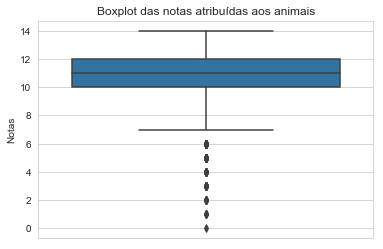

In [84]:
ax = sns.boxplot(
    data=df_tweets_archive[df_tweets_archive.rating_numerator <= 15].rating_numerator)
ax.set_title('Boxplot das notas atribuídas aos animais')
ax.set_ylabel('Notas')
ax.set_xticks([])
fig = ax.get_figure()
fig.savefig('imgs/fig1.png');

#### Insight

Neste gráfico podemos verificar depois de remover as notas discrepantes, ou seja superiores a 15, assim removendo outliers (valores que podiam chegar a 1776, sendo que a nota deveria ser até 10 visto que o denominador é 10 mas os usuários como brincadeira classificam os animais com notas a cima desse valor), e com média de 10.49 e desvio de 2.19. Observa-se que existe uma homogeniedade da variância no boxplot, visto que a diferença entre o terceiro quartil e a mediana assim como a diferença entre o primeiro quartil e a mediana parecem ser a mesmas.

### Relação entre contagem de retweets e tweets favoritos

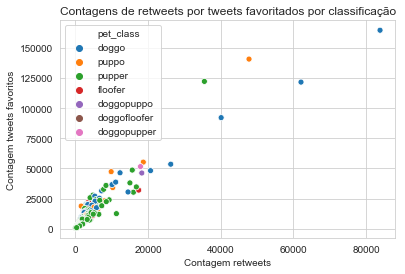

In [85]:
sns.set_style("whitegrid")

ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     hue='pet_class', data=df_tweets_archive)
ax.set_title('Contagens de retweets por tweets favoritados por classificação')
ax.set_xlabel('Contagem retweets')
ax.set_ylabel('Contagem tweets favoritos')
fig = ax.get_figure()
fig.savefig('imgs/fig2.png');

#### Insight

Esse é um gráfico de dispersão, entre a contagem de retweets e a contagem de tweets favoritos para cada classificação. Observa-se que a medida que aumenta a contagem de retweets aumenta a contagem de tweets favoritos (o que pode ser devido a maior visibilidade do tweet) e a classe que possui a maior evidência é a classe pupper. Vale salientar que é possível observar que a classe doggo possui observações com maiores números de retweets, consequentemente, maior contagem de tweets favoritos.

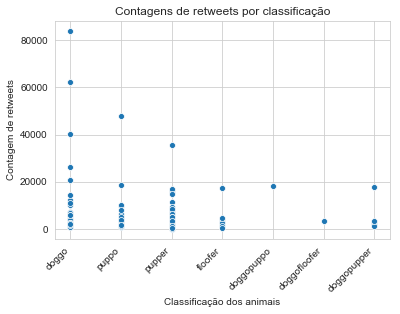

In [86]:
ax = sns.scatterplot(x="pet_class", y="retweet_count", data=df_tweets_archive)
labels = df_tweets_archive.pet_class.unique()[1:]
ax.set_xticklabels(rotation=45, ha='right', labels=labels)
ax.set_title('Contagens de retweets por classificação')
ax.set_xlabel('Classificação dos animais')
ax.set_ylabel('Contagem de retweets')
fig = ax.get_figure()
fig.savefig('imgs/fig3.png');

#### Insight

Por este gráfico é possível verificar que realmente a classificação doggo é a que possui o tweet com maior número de retweets, porém também podemos ver que pupper tem um grande concentração de retweets até 20000. Cachorros que possuem duas classificações são poucos com relação aos demais.

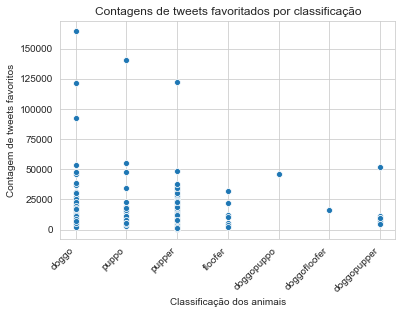

In [87]:
ax = sns.scatterplot(x="pet_class", y="favorite_count", data=df_tweets_archive)
labels = df_tweets_archive.pet_class.unique()[1:]
ax.set_xticklabels(rotation=45, ha='right', labels=labels)
ax.set_title('Contagens de tweets favoritados por classificação')
ax.set_xlabel('Classificação dos animais')
ax.set_ylabel('Contagem de tweets favoritos')
fig = ax.get_figure()
fig.savefig('imgs/fig4.png');

In [88]:
df_tweets_archive[['retweet_count', 'favorite_count']].corr().to_csv('csv/tab4.csv')
df_tweets_archive[['retweet_count', 'favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.929773
favorite_count,0.929773,1.000000


#### Insight

Ao comparar a correlação entre `retweet_count` e `favorite_count` pode-se notar que existe uma forte correlação positiva entre as variáveis, isto é a médida que a contagem de retweets aumenta significa o quão favorito aquele tweet é com os usuários.

### Contagem de tweets por data da post e classificação do animal

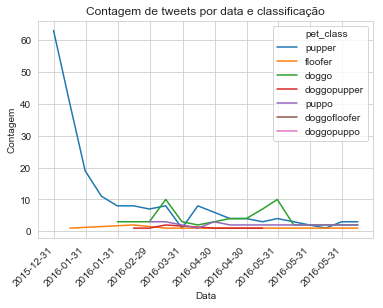

In [89]:
graph = df_tweets_archive.set_index('timestamp')
graph = graph.groupby([pd.Grouper(freq='M'), 'pet_class']).count()
graph = graph.reset_index(level=['timestamp', 'pet_class'])

ax = sns.lineplot(x='timestamp', y='tweet_id', data=graph, hue='pet_class')
ax.set_xticklabels(rotation=45, ha='right', labels=graph.timestamp.dt.date)
ax.set_title('Contagem de tweets por data e classificação')
ax.set_xlabel('Data')
ax.set_ylabel('Contagem')
fig = ax.get_figure()
fig.savefig('imgs/fig5.png');

#### Insight

Ao inicio é possível observar que a grande maioria dos tweets com classificação eram classificados unicamente como pupper, a medida que o tempo passa outras classificações são utilizadas e a contagem de tweets de cachorros denominados como pupper diminuiu. Observa-se que embora tenham ocorrido diferentes classificações, como doggo por exemplo, o número de tweets que possuem os animais denominados nessas classes diminuiu entre os anos.